This notebook is for creating the base ML model.

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [28]:
df.shape

(7319643, 3)

In [29]:
df.head()

datetime  location  busyness
0 2021-01-01         3       132
1 2021-01-01         4       234
2 2021-01-01         5        19
3 2021-01-01         6        37
4 2021-01-01         7       493

In [30]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01       132
4       2021-01-01       234
5       2021-01-01        19
6       2021-01-01        37
7       2021-01-01       493


In [31]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [32]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path="base_model_no_bucketing"
)
print('we made the predictor')

we made the predictor


In [33]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'base_model'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       2.18 GB / 15.90 GB (13.7%)
Disk Space Avail:   2147.51 GB / 2794.50 GB (76.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%), 261 time series. M

In [34]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.135472     675.792183          98.865131          7
1     SeasonalNaive  -1.339581       1.131238           4.691781          2
2     DirectTabular  -1.823986      42.484293         174.628401          4
3  RecursiveTabular  -1.856304     576.186829         343.895103          3
4             Theta  -2.269781      51.604989           4.627172          6
5             Naive  -2.354159       4.384834           4.955665          1
6               ETS  -9.005625     207.403722           4.636296          5


In [35]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  150.406304  117.598475  128.811250  136.900164   
        2024-01-02 00:00:00   90.177626   52.017917   65.111703   74.547917   
        2024-01-02 01:00:00  114.632728   72.357663   86.861383   97.305563   
        2024-01-02 02:00:00  102.652654   57.051175   72.696661   83.999238   
        2024-01-02 03:00:00   65.333512   16.578357   33.302532   45.379559   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.180407  -13.387425   -8.386960   -4.778570   
        2022-04-23 14:00:00    1.166716  -13.403675   -8.401150   -4.791321   
        2022-04-23 15:00:00    1.164488  -13.409980   -8.405470   -4.796331   
        2022-04-23 16:00:00    1.160578  -13.417217   -8.409801   -4.800188   
        2022-04-23 17:00:00    1.177084  -13.415267 

data with frequency 'None' has been resampled to frequency 'h'.


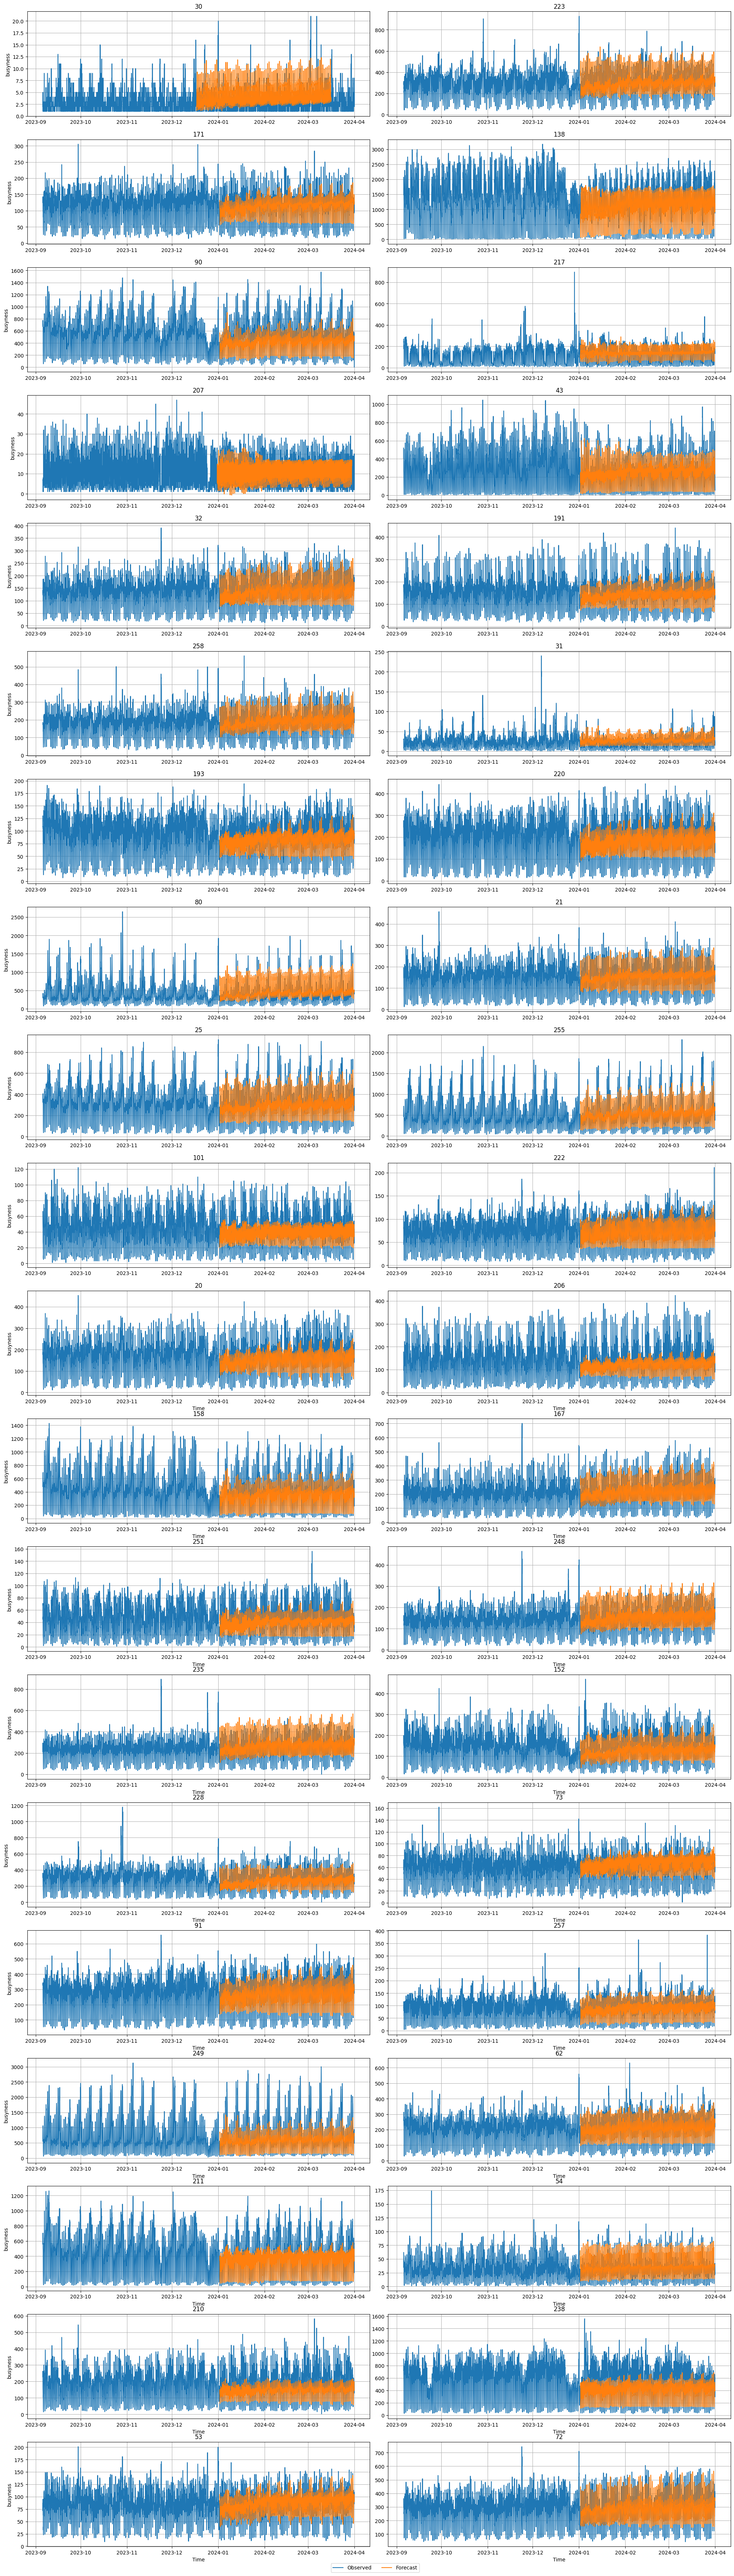

In [36]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=40)


In [37]:
ax = plot.gca()
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
ax.set_xlim([xmin, xmax])

(19783.0, 19813.999988425927)

In [38]:
plot.savefig("test-plot.png")

In [39]:
plt.show()